In [1]:
!pip install optuna --quiet

In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

[I 2025-08-05 08:14:58,815] A new study created in memory with name: no-name-398af828-13e6-448f-8214-1d5486178b3b
[I 2025-08-05 08:15:25,986] Trial 0 finished with value: 0.5973959663007403 and parameters: {'hidden_dim1': 100, 'hidden_dim2': 102, 'dropout': 0.3246520504982918, 'lr': 0.00020720056076457694, 'batch_size': 256}. Best is trial 0 with value: 0.5973959663007403.
[I 2025-08-05 08:15:41,957] Trial 1 finished with value: 0.6488586692569208 and parameters: {'hidden_dim1': 199, 'hidden_dim2': 76, 'dropout': 0.21632381218745106, 'lr': 0.0005722492420403203, 'batch_size': 256}. Best is trial 1 with value: 0.6488586692569208.
[I 2025-08-05 08:15:57,929] Trial 2 finished with value: 0.660253402158611 and parameters: {'hidden_dim1': 134, 'hidden_dim2': 88, 'dropout': 0.34693970036541544, 'lr': 0.0012748395180989373, 'batch_size': 256}. Best is trial 2 with value: 0.660253402158611.
[I 2025-08-05 08:16:20,138] Trial 3 finished with value: 0.6557687751717602 and parameters: {'hidden_dim

Best Params: {'hidden_dim1': 66, 'hidden_dim2': 53, 'dropout': 0.4091386964275948, 'lr': 0.008331419334917479, 'batch_size': 128}

✅ Final Classification Report
              precision    recall  f1-score   support

           0       0.75      0.48      0.59      2000
           1       0.62      0.84      0.71      2000

    accuracy                           0.66      4000
   macro avg       0.68      0.66      0.65      4000
weighted avg       0.68      0.66      0.65      4000



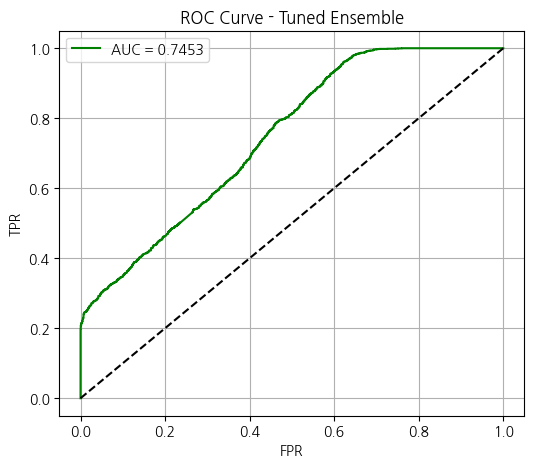

In [3]:
# 📦 라이브러리 로드
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings("ignore")

# 📌 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']
df['Resigned'] = df['Resigned'].astype(int)

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 📌 클래스 균형 맞춤 (언더샘플링 + 오버샘플링)
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)

X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

# 📌 스케일링 및 텐서 변환
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# 🧠 튜닝 가능한 MLP 모델
class TunedMLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1)
        )
    def forward(self, x):
        return self.net(x)

# 🧠 튜닝 가능한 DeepMLP 모델
class TunedDeepMLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# 🧪 Optuna Objective 정의
def objective(trial):
    hidden1 = trial.suggest_int('hidden_dim1', 64, 256)
    hidden2 = trial.suggest_int('hidden_dim2', 32, 128)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    epochs = 20

    model1 = TunedMLP(X_train.shape[1], hidden1, hidden2, dropout).to(device)
    model2 = TunedDeepMLP(X_train.shape[1], hidden1, hidden2, dropout).to(device)
    criterion = nn.BCEWithLogitsLoss()

    def train_single(model):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for _ in range(epochs):
            model.train()
            for xb, yb in loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
        model.eval()
        with torch.no_grad():
            pred = model(X_test_tensor)
            probs = torch.sigmoid(pred).cpu().numpy().flatten()
        return probs

    probs1 = train_single(model1)
    probs2 = train_single(model2)
    probs_ensemble = (probs1 + probs2) / 2
    preds = (probs_ensemble >= 0.5).astype(int)
    score = f1_score(y_test, preds)
    return score

# 🔍 Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# 📌 최적 하이퍼파라미터 출력
best_params = study.best_params
print("Best Params:", best_params)

# 🧠 최종 모델 정의 및 학습
final_model1 = TunedMLP(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['dropout']).to(device)
final_model2 = TunedDeepMLP(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['dropout']).to(device)

def train_final(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
    loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
    for _ in range(20):
        model.train()
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = nn.BCEWithLogitsLoss()(pred, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
    return probs

# 🔧 최종 예측
final_probs1 = train_final(final_model1)
final_probs2 = train_final(final_model2)
final_ensemble_probs = (final_probs1 + final_probs2) / 2
final_preds = (final_ensemble_probs >= 0.5).astype(int)

# 📊 최종 평가
print("\n✅ Final Classification Report")
print(classification_report(y_test, final_preds))

# 📈 ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, final_ensemble_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Tuned Ensemble")
plt.legend()
plt.grid()
plt.show()